In [39]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import seaborn as sns
import matplotlib.pyplot as plt

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_HDF-N/data/holes_HDF-N_irac1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')

In [3]:
#Final.write('./data/testMoc.fits', overwrite=True)

In [28]:
area_hdfn = Sel_func.area_sq_deg
area_hdfn

0.656498573114585

## Calculate density sources in different fields

In [124]:
def density_sources(pathfile, name, save=False):
    # Read in catalogue
    cat = Table.read(pathfile)
    
    # Create moc from catalogue
    MOC = xidplus.moc_routines.create_MOC_from_cat(cat['RA'], cat['Dec'])
    if save==True:
        MOC.write('./data/'+name+'.fits')
        
    # Area from moc in sq_deg
    MOCarea = MOC.area_sq_deg
    
    # Density
    density = len(cat) / MOCarea
    print(name, ' - number density: {:.2f}'.format(density))
    
#     return density


### HDF-N

In [125]:
hdfn_spire_newPSF = '../dmu26_XID+SPIRE_HDF-N/data/20201112/dmu26_XID+SPIRE_HDF-N_cat_20201118.fits'
hdfn_spire_oldPSF = '../dmu26_XID+SPIRE_HDF-N/data/prev/dmu26_XID+SPIRE_HDF-N_cat.fits'
hdfn_spire_Ldust = '../dmu26_XID+SPIRE_HDF-N/data/Ldust/dmu26_XID+SPIRE_HDF-N_cat_20191015.fits'
hdfn_spire_ipac = '../dmu26_XID+SPIRE_HDF-N/data/ipac/dmu26_XID+SPIRE_HDF-N_cat_20201127.fits'

In [126]:
density_sources(hdfn_spire_oldPSF, 'HDF-N newPSF cat')

HDF-N newPSF cat  - number density: 80482.78


In [127]:
density_sources(hdfn_spire_newPSF, 'HDF-N oldPSF cat')

HDF-N oldPSF cat  - number density: 87601.28


In [128]:
density_sources(hdfn_spire_Ldust, 'HDF-N Ldust cat')

HDF-N Ldust cat  - number density: 6875.28


In [132]:
# Read in catalogue
hdfn_newLdust = '../dmu26_XID+SPIRE_HDF-N/data/prior_fpred_f5.fits'
density_sources(hdfn_newLdust, 'HDF-N newLdust cat')

HDF-N newLdust cat  - number density: 8693.02


In [129]:
density_sources(hdfn_spire_ipac, 'HDF-N ipac cat')

HDF-N ipac cat  - number density: 13772.75


In [133]:
# Read in catalogues
akarinep_SPIREcat = '../dmu26_XID+SPIRE_AKARI-NEP/data/dmu26_XID+SPIRE_AKARI-NEP_cat_20191105.fits'
density_sources(akarinep_SPIREcat, 'AKARI-NEP')

AKARI-NEP  - number density: 17996.99


In [134]:
# Read in catalogues
akarisep_SPIREcat = '../dmu26_XID+SPIRE_AKARI-SEP/data/dmu26_XID+SPIRE_AKARI-SEP_cat_20190916.fits'
density_sources(akarisep_SPIREcat, 'AKARI-SEP')

AKARI-SEP  - number density: 17400.67


In [135]:
# Read in catalogue
Bootes_SPIREcat = '../dmu26_XID+SPIRE_Bootes/data/dmu26_XID+SPIRE_Bootes_cat_20190325.fits'
density_sources(Bootes_SPIREcat, 'Bootes')

Bootes  - number density: 50340.01


In [136]:
# Read in catalogues
egs_SPIREcat = '../dmu26_XID+SPIRE_EGS/data/dmu26_XID+SPIRE_EGS_cat_20191007.fits'
density_sources(egs_SPIREcat, 'EGS')

EGS  - number density: 65390.75


In [137]:
# Read in catalogues
elaisSPIREcatSERVS = '../dmu26_XID+SPIRE_ELAIS-N1/data/dmu26_XID+SPIRE_ELAIS-N1_SERVS_cat_20170725.fits'
elaisSPIREcatSWIRE = '../dmu26_XID+SPIRE_ELAIS-N1/data/dmu26_XID+SPIRE_ELAIS-N1_SWIRE_cat_20170808.fits'

density_sources(elaisSPIREcatSERVS, 'ELAIS-N1 -SERVS')
density_sources(elaisSPIREcatSWIRE, 'ELAIS-N1 -SWIRE')

ELAIS-N1 -SERVS  - number density: 43650.47
ELAIS-N1 -SWIRE  - number density: 21484.95


In [138]:
# Read in catalogues
elaisN2_SPIREcat = '../dmu26_XID+SPIRE_ELAIS-N2/data/output/dmu26_XID+SPIRE_ELAIS-N2_cat_20181112.fits'
density_sources(elaisN2_SPIREcat, 'ELAIS-N2')

ELAIS-N2  - number density: 19531.78


In [139]:
# Read in catalogues
gama09_SPIREcat = '../dmu26_XID+SPIRE_GAMA-09/data/dmu26_XID+SPIRE_GAMA-09_20180508.fits'
density_sources(gama09_SPIREcat, 'GAMA-09 Ldust')

GAMA-09 Ldust  - number density: 22539.65


In [140]:
# Read in catalogues
hs82_SPIREcat = '../dmu26_XID+SPIRE_Herschel-Stripe-82/data/prior_f5/dmu26_XID+SPIRE_Herschel-Stripe-82_cat_20200608.fits'
density_sources(hs82_SPIREcat, 'HS-82 Ldust')

HS-82 Ldust  - number density: 11196.40


In [141]:
# Read in catalogues
ngp_SPIREcat = '../dmu26_XID+SPIRE_NGP/data/dmu26_XID+SPIRE_NGP_20190310.fits'
density_sources(ngp_SPIREcat, 'NGP - Ldust')

NGP - Ldust  - number density: 7336.47


In [142]:
# Read in catalogues
ssdf_SPIREcat = '../dmu26_XID+SPIRE_SSDF/data/dmu26_XID+SPIRE_SSDF_cat_20200109.fits'
density_sources(ssdf_SPIREcat, 'SSDF - Ldust')

SSDF - Ldust  - number density: 39586.11


In [142]:
# Read in catalogues
ssdf_SPIREcat = '../dmu26_XID+SPIRE_SSDF/data/dmu26_XID+SPIRE_SSDF_cat_20200109.fits'
density_sources(ssdf_SPIREcat, 'SSDF - Ldust')

SSDF - Ldust  - number density: 39586.11


## Read in XID+MIPS catalogue

In [6]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_HDF-N/data/20201112/3/dmu26_XID+MIPS_HDF-N_cat_20201113.fits')

In [23]:
len(elaisSPIREcatSWIRE) / swireMOCarea


21484.94896269418

4.8905325
258


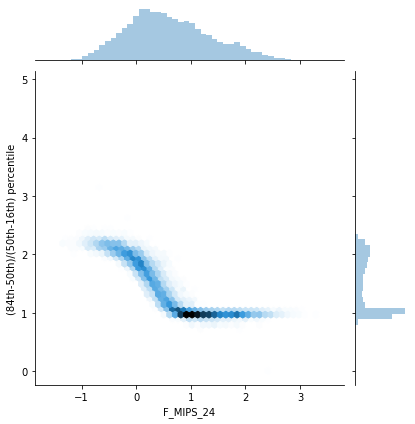

In [8]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 4 \mathrm{\mu Jy}$

In [9]:
good=XID_MIPS['F_MIPS_24']>4
print(len(good))

13406


In [10]:
good.sum()

6103

In [12]:
good.sum() / area_hdfn

9296.288293584432

## Read in Maps

In [9]:
pswfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/HDF-N_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/HDF-N_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/HDF-N_SPIRE500_v1.0.fits'#SPIRE 500 map

#output folder
output_folder='./data/'

In [10]:

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['IMAGE'].header

im250=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim250=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['IMAGE'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['IMAGE'].header

im350=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim350=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['IMAGE'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['IMAGE'].header

im500=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim500=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['IMAGE'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [11]:
## Set XID+ prior class

In [12]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Sel_func)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_HDF-N_cat_20201113.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Sel_func)
prior350.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_HDF-N_cat_20201113.fits',ID=XID_MIPS['help_id'][good])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Sel_func)
prior500.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_HDF-N_cat_20201113.fits',ID=XID_MIPS['help_id'][good])
prior500.prior_bkg(-5.0,5)

In [13]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [14]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/20201112/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 9 tiles required for input catalogue and 1 large tiles


SystemExit: 